# Rob Sandbox
- Tests and trials developed by Rob

# Imports

## Standard library imports

## Local application imports

## Third party imports

In [1]:
import pandas as pd

import numpy as np

import networkx as nx

import scipy.sparse
from scipy.sparse import csr_matrix

import matplotlib.pyplot as plt

# Reading and cleaning data 

## Reading data from csv

In [2]:
dfx = pd.read_csv("Cooffending.csv")

In [5]:
dfx

,OffenderIdentifier,OffenderGender,CrimeIdentifier,CrimeType1,CrimeType2,CrimeType3,CrimeType4,Municipality,CrimeLocation,NumberYouthOffenders,NumberAdultOffenders,CrimeDate,CrimeYear
0,1,F,1085034,3530.0,NaN,NaN,NaN,58227,2.0,0,1,12/17/2005,2005
1,2,F,1431379,1430.0,NaN,NaN,NaN,94068,5.0,0,1,04/23/2008,2008
2,4,M,167174,1430.0,21702.0,NaN,NaN,49058,2.0,0,1,03/06/2008,2008
3,5,M,1179096,1420.0,NaN,NaN,NaN,65005,71.0,0,1,08/21/2008,2008
4,17,M,1270690,1625.0,NaN,NaN,NaN,23027,NaN,0,3,04/30/2003,2003
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1280454,670532,F,1112491,1330.0,NaN,NaN,NaN,58227,34.0,0,1,03/26/2009,2009
1280455,670533,M,78081,21702.0,NaN,NaN,NaN,46075,10.0,0,4,06/29/2009,2009
1280456,670534,M,187904,21201.0,21702.0,NaN,NaN,31015,1.0,0,4,03/16/2009,2009
1280457,670535,M,523837,21704.0,NaN,NaN,NaN,98806,1.0,0,1,10/18/2009,2009


## Cleaning data

### Eliminating duplicated rows

In [16]:
dfxc = dfx.drop_duplicates(subset =["OffenderIdentifier", "CrimeIdentifier"]).copy()

### Reformatting columns for adjacent matrix

In [17]:
for col in ['CrimeIdentifier', 'OffenderIdentifier']:
    dfxc[col] = dfxc[col].astype("category").astype("int64")

### Reindexing selected variables

In [18]:
dfxc["Crimen"] = pd.factorize(dfxc["CrimeIdentifier"])[0]
dfxc["Criminales"] = pd.factorize(dfxc["OffenderIdentifier"])[0]

---

# Creating matrix for analysis

## Converting to numpy array and creating simplified matrix

In [19]:
column = np.array(dfxc["Crimen"]) 
row = np.array(dfxc["Criminales"])

dfxc[['Criminales','Crimen']]

dfxf = np.column_stack([np.ones((dfxc.shape[0]), dtype=int), row, column])
dfxf.shape

(1279987, 3)

## Generating adjacency matrix

### Data with sparse matrix

In [9]:
crime_matrix = csr_matrix(
    (dfxf[:, 0], (dfxf[:, 1], dfxf[:, 2])),
    shape=(row.max() + 1, dfxf[:, 2].max() + 1)
)

### Adjacency matrix

In [10]:
A = crime_matrix*crime_matrix.T

---

# Creating Graph object

## Eliminating self loops


In [11]:
A.setdiag(0)

## Eliminate zeros
- Keeping only data with common crimes

In [12]:
A.eliminate_zeros()

## Creating graph and editing graph

### Generate graph

In [13]:
G = nx.from_scipy_sparse_matrix(A)

### Eliminate nodes without edges

In [14]:
G.remove_nodes_from(list(nx.isolates(G))) #len(list(nx.isolates(G)))

# Exploring graph object

## Initial graph data

In [15]:
G.number_of_nodes()

121159

In [16]:
G.number_of_edges()

178413

## Histogram with cluster's coefficient

(array([72832.,  1535.,  1345.,  4035.,  1116.,  1919.,  1005.,   313.,
          361., 36698.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

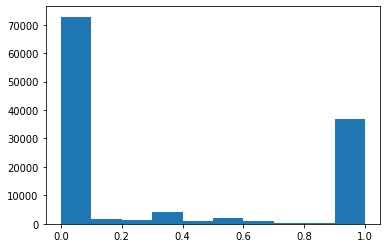

In [24]:
data = list(nx.clustering(G).items())
H = np.array(data)

plt.hist(H[:, 1])

## Filtering connections with high weights

### Creating new graph object

In [51]:
Gf = nx.from_scipy_sparse_matrix(A)
Gf.remove_nodes_from(list(nx.isolates(G)))

### Removing all nodes with less edges than the value specified

In [52]:
threshold = 30

In [53]:
Gf_edges = list(Gf.edges())
Gf_edges_weight = nx.get_edge_attributes(Gf, "weight")

for e in Gf_edges:
    if Gf_edges_weight[e] < threshold:
        Gf.remove_edge(e[0], e[1])
        

In [55]:
Gf.remove_nodes_from(list(nx.isolates(Gf)))

In [56]:
Gf.number_of_nodes()

66

## Network graph

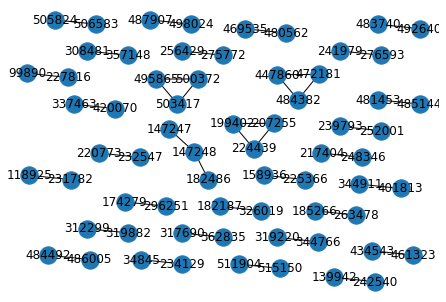

In [57]:
nx.draw(
    Gf,
    pos=nx.drawing.nx_agraph.graphviz_layout(Gf),
    with_labels=True
)

---
---